In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

In [2]:
# Define all used color spaces
def colorSpace(image, color):
    
    if color == 'rgb_r':
        return image[:,:,0]
    if color == 'rgb_g':
        return image[:,:,1]
    if color == 'rgb_b':
        return image[:,:,2]
    
    if color == 'hls_h':
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        return hls[:,:,0]
    if color == 'hls_l':
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        return hls[:,:,1]
    if color == 'hls_s':
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        return hls[:,:,2]
    
    if color == 'yuv_y':
        yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        return yuv[:,:,0]
    if color == 'yuv_u':
        yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        return yuv[:,:,1]
    if color == 'yuv_v':
        yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        return yuv[:,:,2]
    
    if color == 'lab_l':
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        return lab[:,:,0]
    if color == 'lab_a':
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        return lab[:,:,1]
    if color == 'lab_b':
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        return lab[:,:,2]
    
    if color == 'gray':
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    return None

In [3]:
def normalizeLayer(layer):
    
    # could be needed
    #layer = np.array(layer, dtype=np.float32)
    
    x_min = (layer.min())
    x_max = (layer.max())
    
    # ensure we have 0 bias!
    a     = -0.5
    b     =  0.5
    
    # type should be f32 from start!
    return ( a + ( b - a ) * np.divide( ( layer - x_min ),  ( x_max - x_min ) ) )

In [4]:
# hog fetures are allright, BUT then we need to normalize to 0 as keras would
# prefer that. It is also convenient to do this PER layer, as in batch 
# normalization too. Should work with images too!
def normalizeVolume(volume):
    
    # could be needed
    #volume = np.array(volume, dtype=np.float32)
    
    # get dimensions, I asssume last dimension depicts layers/bins
    bins = volume.shape[-1]
    
    # normalize and unbias each layer
    for bin in range(bins):
        layer = volume[:, :, bin]
        volume[:, :, bin] = normalizeLayer(layer)
        
    return volumeData

In [5]:
def zeroOneRange(img):
    
    maxVal = img.max()
    
    if maxVal > 1.00001:
        # promote to float32
        img = np.asarray(img, dtype=np.float32)
        # We assume range is 0 to 255
        img = np.divide(img, 255.0)
        
    return img

In [6]:
# it seems that hog works best on the Y channel, this makes sense according
# o some object recognition papers as well
# this replaces hog features
def hogFeatures(img, 
                color='yuv_y',
                orient=9, 
                pix_per_cell=8,
                norm=False,
                chkrange=True):
    
    if chkrange:
        # check range, should fix type
        img = zeroOneRange(img)
    
    # Apply image color space transform
    img = colorSpace(img, color)
    
    # Obtain hog feaures of image, cells per block of 2x2 was
    # selected as it is the simplest max pool layout, we will feed
    # the features to a conv branch of a DNN, so we have to make a
    
    # few careful considerations (sizes, pooling, 'alignment'),
    # normalization, color space, etc...
    features = hog(img, 
                   orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(2, 2), 
                   transform_sqrt=True, 
                   visualise=False, 
                   feature_vector=False)
    
    # Now, the issue is that the blocks kind of repeat cells, so we might want
    # to use a maxpool to 'equalize' the image, a way to do this would be to
    # 'unroll' the cells in blocks, and apply a maxpool 2x2, however, we only
    # want the pooling window to act over the 'intersections' of this reshape,
    # it will need to be a custom reshape since we change the mem layout, and
    # we want to add a 0 value exterior to allow this to be easily handled by 
    # the keras maxpool layer instead of doing it myself. This all reflects,
    # quite expressively, the close relation between hog and the first layer of 
    # a conv. neural network, maybe ven more if we allow hog to consider higher
    # order derivatives, and the maxpool application, and so on. 
    
    # features right now must have shape
    # (nx, ny, cx, cy, bin), and since cx=0,1, cy=0,1, we want a reshape as
    # (nx*2, ny*2, 1, 1, bin), but since we want a border (like keras 'valid')
    # (nx*2 + 2, ny*2 + 2, 1, 1, bin)
    # since we change mem layout, we cannot use reshape, so lets do it!
    nx   = features.shape[0]
    ny   = features.shape[1]
    cx   = 2 # assume constant non param
    cy   = 2 # assume constant non param
    bins = features.shape[4]
    
    # I have thought about other dimensions thant 2, but then I would need to
    # 'interleave' the cells into bins, and it would be harder, moreso if the
    # size is odd and so on... basically, looking for repetitions in the 
    # matrix and appending them one by one on the matrix and so on, possible
    # but harder...
    
    nxp = 2 * nx + 2
    nyp = 2 * ny + 2
    
    final_length = nxp * nyp * bins
    linear = np.zeros((final_length), dtype=np.float32)
    matrix = linear.reshape((nxp, nyp, bins))
    
    # populate the matrix with the 'flattened' hog features
    for nxidx in range(nx):
        for nyidy in range(ny):
            # we are at nxidx, nyidy block
            # this hast cx=2, cy=2 dimensions over cells
            # and each cell has bins dim
            # so get this subelement!
            submatrix = features[nxidx, nyidy, :, :, :]
            # prune spurious dims, maybe not needed though
            submatrix = submatrix.reshape((2, 2, bins))
            # assign to greater matrix, consider that we have a 
            # 1 element offset, also that cell dim is constant and two
            matrix[(1 + 2 * nxidx):(3 + 2 * nxidx),
                   (1 + 2 * nyidy):(3 + 2 * nyidy),
                   :] = submatrix
            
    if norm:
        # and normalize per layer
        matrix = normalizeVolume(matrix)
    
    return matrix

In [7]:
# I will need to create a generator as well, as needed by keras as there are
# 15k images, we also need to feed the color histograms as a vector, and also
# the original image, though with much reduced resolutions, as we care mostly
# about color actually, so maybe we wont even need the color histogram? 
# I mean, we already have the shape information, so it should be possible too
# this replaces bin spatial
def colorFeatures(image, 
                      norm=False,
                      chkrange=True):
    
    if chkrange:
        # check range
        image = zeroOneRange(image)
    
    # First obtain the color maps/transforms of the image, on spaces
    # recommended by udacity, these are rgb and hsv, we want them in 8x8
    # pixel format, so get each layer, and resize it, better to use
    # INTER_AREA for this though
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # input form is rgb images, so this ought to work properly
    rgb = image[:]
    
    # downsize our images, please note, size should mirror the one
    # from hog features to avoid too many branches in network, even if we then
    # prune information, I wonder if max is good in this case though, maybe...
    # It could be ok to apply a first conv layer even here though, lets see
    hsvm = np.zeros((16, 16, 3), dtype=np.float32)
    rgbm = np.zeros((16, 16, 3), dtype=np.float32)
    
    hsvm[:,:,0] = cv2.resize( hsv[:,:,0], (16, 16), interpolation=cv2.INTER_AREA )  
    hsvm[:,:,1] = cv2.resize( hsv[:,:,1], (16, 16), interpolation=cv2.INTER_AREA )  
    hsvm[:,:,2] = cv2.resize( hsv[:,:,2], (16, 16), interpolation=cv2.INTER_AREA )  
    
    rgbm[:,:,0] = cv2.resize( rgb[:,:,0], (16, 16), interpolation=cv2.INTER_AREA )  
    rgbm[:,:,1] = cv2.resize( rgb[:,:,1], (16, 16), interpolation=cv2.INTER_AREA )  
    rgbm[:,:,2] = cv2.resize( rgb[:,:,2], (16, 16), interpolation=cv2.INTER_AREA ) 
    
    if norm:
        # normalize each layer as well
        hsvm = normalizeVolume(hsvm)
        rgbm = normalizeVolume(rgbm)
    
    # prepare are for join, we MUST use DSTACK for this    
    return np.dstack((rgbm, hsvm))

In [8]:
# The other branch of the network will not deal with the image information locally, as hog
# or bin spatial inherently are, but with the color histograms of the entire image to be
# looked all at once, at this point we have (16*16*(9+6)) = 3840 points with local info, 
# histograms should give 32*3*2 (bins*channels*colorspaces) = 192 points, this seems...
# ok...
# please note that range is 0 to 1, as image range for pngs is 0 to 1
def histFeatures( img,
                  nbins=32,
                  bins_range=(0,1),
                  norm=False,
                  chkrange=True):
    
    if chkrange:
        # we could use hsv and rgb color spaces as well though, check range
        img = zeroOneRange(img)
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # And in HSV color space
    channel4_hist = np.histogram(hsv[:,:,0], bins=nbins, range=bins_range)
    channel5_hist = np.histogram(hsv[:,:,1], bins=nbins, range=bins_range)
    channel6_hist = np.histogram(hsv[:,:,2], bins=nbins, range=bins_range)
    
    # We should narmalize them, per channel/layer
    # Though, to be fair, these should be done at the batch level!
    # or entire feature set
    if norm:
        channel1_hist[0] = normalizeLayer(channel1_hist[0])
        channel2_hist[0] = normalizeLayer(channel2_hist[0])
        channel3_hist[0] = normalizeLayer(channel3_hist[0])
        channel4_hist[0] = normalizeLayer(channel4_hist[0])
        channel5_hist[0] = normalizeLayer(channel5_hist[0])
        channel6_hist[0] = normalizeLayer(channel6_hist[0])
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], 
                                    channel2_hist[0], 
                                    channel3_hist[0],
                                    channel4_hist[0], 
                                    channel5_hist[0], 
                                    channel6_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [9]:
# create the generator for keras? Yoy know what, a CNN is not really a good
# fit for this though, lets try a simple SVM, so, obtain a generator, but of
# the features only
# Divide up into cars and notcars, maybe later I will break and adapt this to a
# CNN or something, but I do not have that much time unfortunately, as I would
# need to experiment a LOT!
def separator(pattern='imgs/*.png'):
    
    images  = glob.glob(pattern)
    cars    = []
    notcars = []
    
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)
            
    return cars, notcars

def extractor(files):
    
    allfeatures = []
        
    for file in files:
        image = mpimg.imread(file)
        
        hogf = hogFeatures(image)
        clrf = colorFeatures(image)
        hstf = histFeatures(image)
        
        features = np.concatenate((np.ndarray.flatten(hogf), 
                                   np.ndarray.flatten(clrf),
                                   np.ndarray.flatten(hstf)))
        
        allfeatures.append(features)
        
    return allfeatures

def generator(pattern='imgs/*.png'):
    
    cars, notcars = separator(pattern)
            
    car_features = extractor(cars)
    notcar_features = extractor(notcars)
        
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float32)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    return scaled_X, y, X_scaler

In [10]:
x,y,scaler = generator()

In [11]:
def SVCwrapper(x, y):
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(x, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=rand_state)

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(t2-t, 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
    print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
    # Check the prediction time for a single sample
    t=time.time()
    prediction = svc.predict(X_test[0].reshape(1, -1))
    t2 = time.time()
    print(t2-t, 'Seconds to predict with SVC')
    print(prediction)
    
    return svc

In [12]:
# 99.87! I will not beat that with a NN!
# Just 4 examples were missclassed, ALL
# within a very short distance from 0
svc = SVCwrapper(x,y)

6.176353216171265 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.998720818676
0.0 Seconds to predict with SVC
[ 1.]


In [13]:
def fitExplorer(x, y, svc):
    
    plt.plot(y, 'x')
    plt.show()
    
    predictions = svc.predict(x)
    distances   = svc.decision_function(x)
    plt.plot(distances, '.')
    plt.show()
    
    sortedf = (np.sort(distances))
    inner   = sortedf[(sortedf >= -0.2) & (sortedf <= 0.2)]
    plt.plot(inner, 'o')
    plt.show()

    problem_idx_prednoncar = distances[(predictions < 0.1) & (y > 0.9)]
    plt.plot(problem_idx_prednoncar, 'o')
    plt.show()

    problem_idx_predcar = distances[(predictions > 0.9) & (y < 0.1)]
    plt.plot(problem_idx_predcar, 'o')
    plt.show()

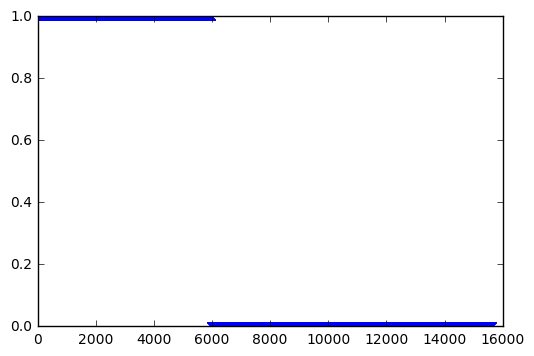

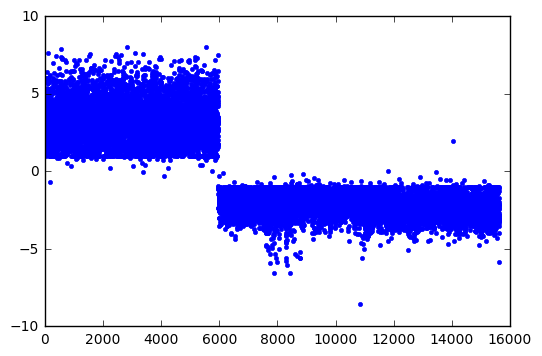

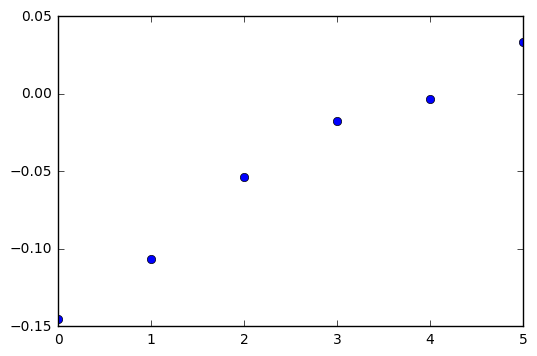

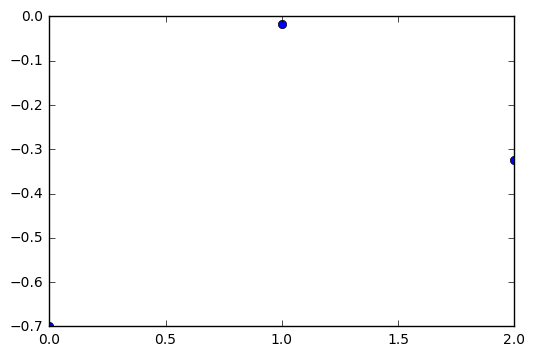

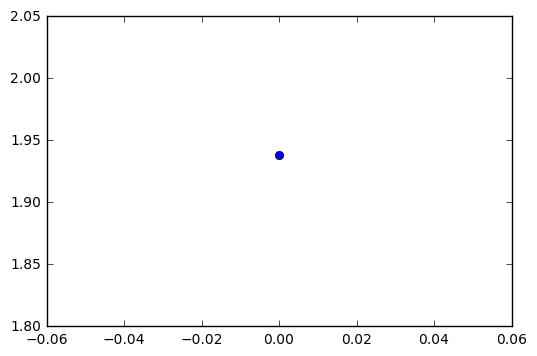

In [14]:
fitExplorer(x, y, svc)

In [244]:
def thresholdedEvaluator(img,
                         svc, 
                         scaler,
                         threshold = 0.2):
    # We want to apply a threshold for identification of cars, as shown in
    # the explored data above, we really want to do this to predict a car, 
    # as dealing with hard negatives is hard
    # 0.2 seems ok from data
    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
    # just in case we have conflicts with png, jpg, mpimg, cv2, etc
    img = zeroOneRange(img)
    # apply feature extractor
    hogf = hogFeatures(img)
    clrf = colorFeatures(img)
    hstf = histFeatures(img)
    features = np.concatenate((np.ndarray.flatten(hogf), 
                               np.ndarray.flatten(clrf),
                               np.ndarray.flatten(hstf)))
    # we need to apply the scaler found for svc
    scaled_x = scaler.transform(features.reshape((1,-1)))
        
    distance = svc.decision_function(scaled_x)
    
    evaluation = distance >= threshold
    
    return evaluation, distance

In [245]:
image = mpimg.imread('cutout6.jpg')
thresholdedEvaluator(image,
                     svc,
                     scaler)

(array([ True], dtype=bool), array([ 3.47749687]))

In [246]:
global counter
counter = 0

def draw_boxes(img, 
               bboxes, 
               color=(0, 0, 255), 
               thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# Adapt sliding window Udacity function to our needs
# assume xy window is ALWAYS square
def slide_window(img, 
                 window_list,
                 x_start_stop=[None, None], 
                 y_center=None,
                 xy_window=(64, 64), 
                 x_overlap=0.75):
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - x_overlap))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    # Loop through finding x windows
    for xs in range(nx_windows):
        # Calculate window position
        startx = xs*nx_pix_per_step + x_start_stop[0]
        endx   = startx + xy_window[0]
        # We will need to fix Y coordinates too, now there might be
        # off by ones, but you know what, I do not care
        starty = y_center - np.around(xy_window[1]/2)
        endy   = y_center + np.around(xy_window[1]/2)
        # Extract inner image with coordinates
        window_image = img[starty:endy, startx:endx, :]
        # extra args must come from outer context
        value, dist = thresholdedEvaluator(window_image, svc, scaler)
        # Append window position to list iff car is found
        #plt.imshow(window_image)
        #plt.show()
        global counter
        counter = counter + 1
        if value:
            window_list.append( ( (np.int(startx), np.int(starty)), (np.int(endx), np.int(endy)), dist ) )
    # Return the list of windows
    return len(window_list), window_list

# apply sliding windows over all the image, with different
# sizes and such depending on general position using helper func
# by udacity, so it should work, maybe...
def slideAll(img,
             nlines = 20,
             nvariations = 4,
             pvariations = 0.25,
             min_pixels = 40,
             overlap = 0.75):
    
    global counter
    counter = 0

    # save all windows here
    window_list = []
    
    # I will need to create sliding zones or something like that
    # starx, endx, starty, endy
    # parameters were carefully chosen, in such a way that a valid
    # area is always generated, though box size might become to small
    # so we chack for that
    top_hportion = 0.7   #horizontal portion at top of vehicle lines
    bot_hportion = 1     #horizontal portion at bottom of vehicles lines
    top_vportion = 0     #vertical idem
    bot_vportion = 0.333 #vertical idem
    top_ydist    = 0.56  #proportion of image distance to top in image
    bot_ydist    = 0.75  #proportion of image distance to top in image
    
    # This really should be done in a way that upper sections are 'denser'
    # so we can do this with a linear scaling! nice actually
    maximal_steps = nlines * (nlines + 1) / 2
    # and arrange as a triangular sum of sorts
    
    # we want to cover from the bottom to the top line, as in a scan by
    # scan fashion, and on each, imagine a vertical box, and its variations
    # so we want to create the x_lengths, do so
    x_image = img.shape[1]
    y_image = img.shape[0]
    y_span  = np.round( y_image * (bot_ydist - top_ydist) )
    y_bot   = np.round( y_image * bot_ydist )
    
    # we will round on a case by case basis
    y_fstep = np.true_divide( y_span, maximal_steps )
    y_rtop  = y_bot - y_fstep * maximal_steps # just for consistency, wont use
    
    # linear scaled steps
    iter_steps = [ nlines - x for x in range(nlines + 1) ]
    iter_sums  = [ sum(iter_steps[0:x]) for x in range(nlines + 1) ]
    
    # implement guard for 'dilution' if too many slices
    y_center_old = 0
    for idx in range(nlines):
        y_center_new = y_bot - np.round(iter_sums[idx] * y_fstep)
        if (abs(y_center_new - y_center_old) <= 1):
            # we calculated the same line +-1px, no point going on
            break;
        y_center_old = y_center_new
        
        # calculate the spans in X
        hportion  = iter_sums[idx] * (bot_hportion - top_hportion) / maximal_steps
        h_idxspan = bot_hportion - hportion
        x_start   = 0.5 * x_image - 0.5 * h_idxspan * x_image
        x_end     = 0.5 * x_image + 0.5 * h_idxspan * x_image
        
        vportion  = iter_sums[idx] * (bot_vportion - top_vportion) / maximal_steps
        v_idxspan = bot_vportion - vportion
        y_span    = v_idxspan * y_image
        
        # round stuff
        x_start = np.round(x_start)
        x_end   = np.round(x_end)
        y_span  = np.round(y_span)
        
        #print((x_start, x_end, y_span, y_center_new))
        
        if y_span < min_pixels:
            #/ (1 - pvariations):
            # windows will be too small, no point going on
            break;
            
        if abs(x_start - x_end) < min_pixels/ (1 - pvariations):
            #idem
            break;
            
        #print((x_start, x_end))
            
        # However we will try with many variations over y_span, so
        # also check those
        varrange = range( nvariations, -nvariations - 1, -1 )
        var_step = np.round( y_span * pvariations / nvariations )
        for idy in varrange:
            # maybe there could be checks here too?
            local_yspan = y_span + idy * var_step
            # somewhat ugly but I dont want to flatten
            finds, window_list = slide_window(img, 
                                              window_list,
                                              x_start_stop=[x_start, x_end], 
                                              y_center=y_center_new,
                                              xy_window=(local_yspan, local_yspan), 
                                              x_overlap=overlap)
                
    return window_list

In [367]:
img = mpimg.imread('test_images/test3.jpg')
window_list = slideAll( img,
                         nlines = 16,
                         nvariations = 2,
                         pvariations = 0.40,
                         min_pixels = 64,
                         overlap = 0.8 )

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


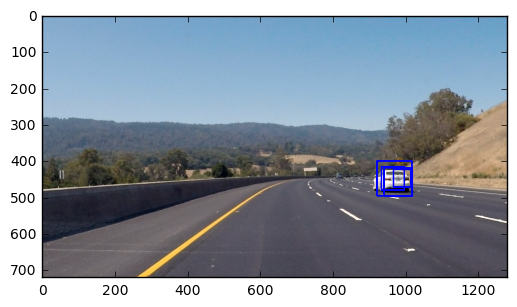

1803


In [368]:
window_img = draw_boxes(img, window_list, color=(0, 0, 255), thick=3)                    
plt.imshow(window_img)
plt.show()
print(counter)

In [344]:
# adapted from https://github.com/quantombone/exemplarsvm/blob/54c07ec4faa96fb949991ebc512eaf7446e034f7/internal/esvm_nms.m
def esvm_nms(boxes, overlap):
    
    boxes = np.asarray(boxes)
    
    top = []
    
    if len(boxes) == 0:
        return top
    
    # extract arrays of cornes
    x1 = np.asarray([bbox[0][0] for bbox in boxes])
    y1 = np.asarray([bbox[0][1] for bbox in boxes])
    x2 = np.asarray([bbox[1][0] for bbox in boxes])
    y2 = np.asarray([bbox[1][1] for bbox in boxes])
    s  = [bbox[2][0] for bbox in boxes]
    
    area = ( x2 - x1 + 1 ) * ( y2 - y1 + 1 )
    sIdx = np.argsort(s)

    pick    = np.zeros_like(s)
    counter = 0
    
    while (len(sIdx) > 0):
        
        last = len(sIdx) - 1
        iidx = sIdx[last]  
        pick[counter] = iidx
        counter = counter + 1

        xx1 = np.maximum(x1[iidx] * np.ones_like(last), x1[sIdx[0:(last)]])
        yy1 = np.maximum(y1[iidx] * np.ones_like(last), y1[sIdx[0:(last)]])
        xx2 = np.minimum(x2[iidx] * np.ones_like(last), x2[sIdx[0:(last)]])
        yy2 = np.minimum(y2[iidx] * np.ones_like(last), y2[sIdx[0:(last)]])

        w = np.maximum(np.zeros_like(last), xx2 - xx1 + 1 )
        h = np.maximum(np.zeros_like(last), yy2 - yy1 + 1 )

        o = np.divide( w * h, area[sIdx[0:(last)]] )
        
        prune_idx =  np.concatenate(( [last], np.nonzero(o > overlap)[0] ))
        sIdx[prune_idx] = -1
        sIdx = [x for x in sIdx if x > -1]
        sIdx = np.asarray(sIdx)

    pick = pick[0:(counter)];
    top = boxes[(pick.astype(int))];
    
    return top

In [375]:
img = mpimg.imread('test_images/test6.jpg')
window_list = slideAll( img,
                         nlines = 16,
                         nvariations = 2,
                         pvariations = 0.40,
                         min_pixels = 64,
                         overlap = 0.8 )

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


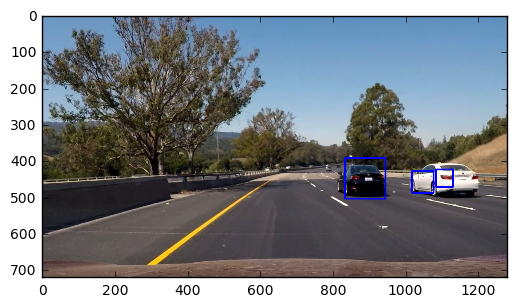

1803


In [377]:
tops = esvm_nms(window_list, 0.0)
window_img = draw_boxes(img, tops, color=(0, 0, 255), thick=3)                    
plt.imshow(window_img)
plt.show()
print(counter)

In [282]:
b = np.ones((10)) + 2

In [283]:
b

array([ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.])

In [310]:
np.concatenate(([0],(np.arange(1,3))))

array([0, 1, 2])

In [285]:
b[np.concatenate(([0],[1, 2, 3]))]

array([ 3.,  3.,  3.,  3.])

In [287]:
b[[1,2,3]]

array([ 3.,  3.,  3.])

In [288]:
c = [1,2,3,4,5]

In [289]:
c[[0,1,2]]

TypeError: list indices must be integers or slices, not list